# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
import numpy as np

(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

4422102/4422102 [==============================] - 1s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
x_train.shape

(60000, 784)

In [3]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer().fit(x_train)
x_train = normalizer.transform(x_train)
x_test = normalizer.transform(x_test)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.

        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        use_PCA, bool: whether to include PCA preprocessing.

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.

        Feel free to edit this template for your preferences.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier

        if self.classifier == 'svm':
            self.classifier_model = SVC()
        elif self.classifier == 'logreg':
            self.classifier_model = LogisticRegression()

        self.pca = PCA(n_components=self.new_dim)
        self.w = None
        self.b = None

    def calculate_sigma(self, X):
        """
        Calculate hyperparametr sigma^2 on random subsample.
        """
        sums = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
        median_value = np.median(sums)
        return median_value

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            X = self.pca.fit_transform(X)

        indices = np.random.choice(X.shape[0], size=1000, replace=False) # size = 1000, т.к. нам необходимо 10^6 объектов, а значит 1000 строк
        sub_X = X[indices]

        sigma = self.calculate_sigma(sub_X)
        self.w = np.random.normal(0, 1/sigma, size=(self.n_features, X.shape[1]))
        self.b = np.random.uniform(-np.pi, np.pi, size=(1, self.n_features))
        phi = np.cos(X @ self.w.T + self.b)
        self.classifier_model.fit(phi, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)

        phi = np.cos(X @ self.w.T + self.b)
        return self.classifier_model.predict_proba(phi)

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)

        phi = np.cos(X @ self.w.T + self.b)
        return self.classifier_model.predict(phi)

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
np.random.seed(42)

model = RFFPipeline()
model.fit(x_train, y_train)
print(f"Result accuracy - {accuracy_score(y_test, model.predict(x_test))} is correct")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Result accuracy - 0.869 is correct


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [6]:
import pandas as pd
import time
import matplotlib.pyplot as plt

In [8]:
df_acc = pd.DataFrame(columns=["model", "PCA", "accuracy", "spend_time"])

In [9]:
np.random.seed(42)

indices = np.random.choice(x_train.shape[0], size=20000, replace=False)
sub_x_train = x_train[indices]
sub_y_train = y_train[indices]

In [10]:
np.random.seed(42)
start_time = time.time()

svm_linear = RFFPipeline(use_PCA=False, classifier="svm")
svm_linear.fit(sub_x_train, sub_y_train)
df_acc.loc[len(df_acc.index)] = ["svm", "False", accuracy_score(y_test, svm_linear.predict(x_test)), (time.time() - start_time)]

In [11]:
np.random.seed(42)
start_time = time.time()

svm_kernel = RFFPipeline(use_PCA=True, classifier="svm")
svm_kernel.fit(sub_x_train, sub_y_train)
df_acc.loc[len(df_acc.index)] = ["svm", "True", accuracy_score(y_test, svm_kernel.predict(x_test)), (time.time() - start_time)]

In [12]:
df_acc

,model,PCA,accuracy,spend_time
0,svm,False,0.8689,232.832446
1,svm,True,0.8667,207.939664


In [13]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00


In [14]:
from catboost import CatBoostClassifier

In [15]:
catboost = CatBoostClassifier(task_type="GPU")

grid = {
    "learning_rate": [0.1, 0.15, 0,2],
    "depth": [6, 7, 8],
    "iterations": [300, 350]
}


In [16]:
grid_search_result = catboost.grid_search(grid, X=x_train, y=y_train, verbose=True)

0:	learn: 1.8847046	test: 1.8870021	best: 1.8870021 (0)	total: 143ms	remaining: 42.7s
1:	learn: 1.6665628	test: 1.6686383	best: 1.6686383 (1)	total: 227ms	remaining: 33.8s
2:	learn: 1.5045758	test: 1.5074482	best: 1.5074482 (2)	total: 309ms	remaining: 30.6s
3:	learn: 1.3786750	test: 1.3819261	best: 1.3819261 (3)	total: 404ms	remaining: 29.9s
4:	learn: 1.2807249	test: 1.2841497	best: 1.2841497 (4)	total: 503ms	remaining: 29.7s
5:	learn: 1.1970295	test: 1.2000037	best: 1.2000037 (5)	total: 601ms	remaining: 29.4s
6:	learn: 1.1274620	test: 1.1303560	best: 1.1303560 (6)	total: 718ms	remaining: 30.1s
7:	learn: 1.0650308	test: 1.0679054	best: 1.0679054 (7)	total: 823ms	remaining: 30s
8:	learn: 1.0080343	test: 1.0116405	best: 1.0116405 (8)	total: 934ms	remaining: 30.2s
9:	learn: 0.9630544	test: 0.9668140	best: 0.9668140 (9)	total: 1.04s	remaining: 30.2s
10:	learn: 0.9202364	test: 0.9240363	best: 0.9240363 (10)	total: 1.14s	remaining: 30.1s
11:	learn: 0.8812194	test: 0.8850555	best: 0.8850555 (

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.5881543	test: 2.6674106	best: 2.6674106 (0)	total: 58.7ms	remaining: 17.6s
1:	learn: 162.9630104	test: 164.5587396	best: 2.6674106 (0)	total: 111ms	remaining: 16.6s
2:	learn: 379.3948333	test: 382.0101250	best: 2.6674106 (0)	total: 165ms	remaining: 16.3s
3:	learn: 360.0817917	test: 361.9993333	best: 2.6674106 (0)	total: 223ms	remaining: 16.5s
4:	learn: 275.1992500	test: 272.8761875	best: 2.6674106 (0)	total: 277ms	remaining: 16.4s
5:	learn: 254.4570000	test: 252.9095208	best: 2.6674106 (0)	total: 331ms	remaining: 16.2s
6:	learn: 257.4706458	test: 256.5582292	best: 2.6674106 (0)	total: 385ms	remaining: 16.1s
7:	learn: 307.6389583	test: 308.2269792	best: 2.6674106 (0)	total: 436ms	remaining: 15.9s
8:	learn: 243.0427292	test: 245.0421667	best: 2.6674106 (0)	total: 490ms	remaining: 15.8s
9:	learn: 263.4097708	test: 264.0831250	best: 2.6674106 (0)	total: 543ms	remaining: 15.7s
10:	learn: 231.8451250	test: 234.0648958	best: 2.6674106 (0)	total: 596ms	remaining: 15.7s
11:	learn: 2

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.5881540	test: 2.6674108	best: 2.6674108 (0)	total: 60.7ms	remaining: 21.2s
1:	learn: 162.9630417	test: 164.5587292	best: 2.6674108 (0)	total: 116ms	remaining: 20.1s
2:	learn: 379.3949167	test: 382.0101667	best: 2.6674108 (0)	total: 174ms	remaining: 20.1s
3:	learn: 360.0817917	test: 361.9994167	best: 2.6674108 (0)	total: 229ms	remaining: 19.8s
4:	learn: 275.1992917	test: 272.8762083	best: 2.6674108 (0)	total: 294ms	remaining: 20.3s
5:	learn: 254.4570000	test: 252.9094792	best: 2.6674108 (0)	total: 349ms	remaining: 20s
6:	learn: 257.4706250	test: 256.5582083	best: 2.6674108 (0)	total: 406ms	remaining: 19.9s
7:	learn: 307.6389167	test: 308.2269583	best: 2.6674108 (0)	total: 460ms	remaining: 19.7s
8:	learn: 243.0427500	test: 245.0421458	best: 2.6674108 (0)	total: 517ms	remaining: 19.6s
9:	learn: 263.4098333	test: 264.0831042	best: 2.6674108 (0)	total: 572ms	remaining: 19.5s
10:	learn: 231.8451667	test: 234.0648958	best: 2.6674108 (0)	total: 626ms	remaining: 19.3s
11:	learn: 215

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.4546216	test: 2.5029811	best: 2.5029811 (0)	total: 97.2ms	remaining: 29.1s
1:	learn: 132.8976250	test: 135.2916979	best: 2.5029811 (0)	total: 191ms	remaining: 28.5s
2:	learn: 266.1970833	test: 272.5891667	best: 2.5029811 (0)	total: 284ms	remaining: 28.1s
3:	learn: 261.8176667	test: 265.5877083	best: 2.5029811 (0)	total: 397ms	remaining: 29.4s
4:	learn: 193.5502917	test: 196.5009792	best: 2.5029811 (0)	total: 491ms	remaining: 29s
5:	learn: 217.4606458	test: 223.0879792	best: 2.5029811 (0)	total: 586ms	remaining: 28.7s
6:	learn: 215.3035625	test: 217.9967917	best: 2.5029811 (0)	total: 696ms	remaining: 29.1s
7:	learn: 170.3837708	test: 173.5386354	best: 2.5029811 (0)	total: 792ms	remaining: 28.9s
8:	learn: 156.5737083	test: 156.0675000	best: 2.5029811 (0)	total: 892ms	remaining: 28.8s
9:	learn: 155.2143125	test: 157.1351979	best: 2.5029811 (0)	total: 987ms	remaining: 28.6s
10:	learn: 136.3670833	test: 137.1239167	best: 2.5029811 (0)	total: 1.08s	remaining: 28.5s
11:	learn: 130

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.4546217	test: 2.5029811	best: 2.5029811 (0)	total: 110ms	remaining: 38.6s
1:	learn: 132.8976250	test: 135.2916979	best: 2.5029811 (0)	total: 206ms	remaining: 35.9s
2:	learn: 266.1970833	test: 272.5892292	best: 2.5029811 (0)	total: 299ms	remaining: 34.6s
3:	learn: 261.8176458	test: 265.5876875	best: 2.5029811 (0)	total: 400ms	remaining: 34.6s
4:	learn: 193.5502083	test: 196.5009792	best: 2.5029811 (0)	total: 496ms	remaining: 34.2s
5:	learn: 217.4606458	test: 223.0879792	best: 2.5029811 (0)	total: 592ms	remaining: 33.9s
6:	learn: 215.3035208	test: 217.9967708	best: 2.5029811 (0)	total: 694ms	remaining: 34s
7:	learn: 170.3837500	test: 173.5386354	best: 2.5029811 (0)	total: 794ms	remaining: 33.9s
8:	learn: 156.5737083	test: 156.0674896	best: 2.5029811 (0)	total: 908ms	remaining: 34.4s
9:	learn: 155.2142917	test: 157.1351979	best: 2.5029811 (0)	total: 995ms	remaining: 33.8s
10:	learn: 136.3670938	test: 137.1238854	best: 2.5029811 (0)	total: 1.09s	remaining: 33.7s
11:	learn: 130.

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.2829845	test: 2.3297326	best: 2.3297326 (0)	total: 176ms	remaining: 52.5s
1:	learn: 122.8745104	test: 123.5261354	best: 2.3297326 (0)	total: 343ms	remaining: 51.1s
2:	learn: 246.7418750	test: 246.0130000	best: 2.3297326 (0)	total: 518ms	remaining: 51.3s
3:	learn: 217.6665625	test: 216.8684792	best: 2.3297326 (0)	total: 677ms	remaining: 50.1s
4:	learn: 195.6416875	test: 194.4228333	best: 2.3297326 (0)	total: 843ms	remaining: 49.7s
5:	learn: 227.5763542	test: 224.1154792	best: 2.3297326 (0)	total: 1.02s	remaining: 50s
6:	learn: 189.2648333	test: 188.6315833	best: 2.3297326 (0)	total: 1.2s	remaining: 50.2s
7:	learn: 177.2505833	test: 176.9122708	best: 2.3297326 (0)	total: 1.37s	remaining: 50.1s
8:	learn: 152.2229479	test: 150.9864271	best: 2.3297326 (0)	total: 1.55s	remaining: 50.1s
9:	learn: 142.2248958	test: 141.9052083	best: 2.3297326 (0)	total: 1.73s	remaining: 50s
10:	learn: 124.9814583	test: 125.0377396	best: 2.3297326 (0)	total: 1.92s	remaining: 50.3s
11:	learn: 121.014

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.2829850	test: 2.3297324	best: 2.3297324 (0)	total: 190ms	remaining: 1m 6s
1:	learn: 122.8745313	test: 123.5261562	best: 2.3297324 (0)	total: 362ms	remaining: 1m 3s
2:	learn: 246.7418542	test: 246.0130000	best: 2.3297324 (0)	total: 540ms	remaining: 1m 2s
3:	learn: 217.6665625	test: 216.8685000	best: 2.3297324 (0)	total: 697ms	remaining: 1m
4:	learn: 195.6416875	test: 194.4228333	best: 2.3297324 (0)	total: 871ms	remaining: 1m
5:	learn: 227.5763958	test: 224.1155000	best: 2.3297324 (0)	total: 1.04s	remaining: 60s
6:	learn: 189.2648750	test: 188.6315833	best: 2.3297324 (0)	total: 1.22s	remaining: 59.7s
7:	learn: 177.2505625	test: 176.9122708	best: 2.3297324 (0)	total: 1.4s	remaining: 59.7s
8:	learn: 152.2229688	test: 150.9864271	best: 2.3297324 (0)	total: 1.58s	remaining: 59.8s
9:	learn: 142.2248854	test: 141.9051875	best: 2.3297324 (0)	total: 1.75s	remaining: 59.6s
10:	learn: 124.9814792	test: 125.0377500	best: 2.3297324 (0)	total: 1.94s	remaining: 59.7s
11:	learn: 121.0145313

In [17]:
grid_search_result["params"]

{'depth': 8, 'iterations': 350, 'learning_rate': 0.15}

In [18]:
catboost_best = CatBoostClassifier(**(grid_search_result['params']), task_type="GPU")

In [20]:
np.random.seed(42)
start_time = time.time()

catboost_best.fit(x_train,  y_train, silent=True)
df_acc.loc[len(df_acc.index)] = ["catboost", "False", accuracy_score(y_test, catboost_best.predict(x_test)), (time.time() - start_time)]
print(f"accuracy_score Test:", accuracy_score(y_test, catboost_best.predict(x_test)))

accuracy_score Test: 0.8888


In [21]:
df_acc

,model,PCA,accuracy,spend_time
0,svm,False,0.8689,232.832446
1,svm,True,0.8667,207.939664
2,catboost,False,0.8888,80.679845


Первое, что хочется отметить, что качество моделей зависит от объема выборки, на которой мы обучаем. Я взяла 20 000 объектов, чтобы эксперименты были не такими долгими.


Рассматривая идею **PCA** на алгоритме **SVM** при дефолтных параметрах, можно заметить, что модель дает чуть худшие результаты в сравнении с обычным SVM. В конечном итоге лучшее качество показывает **catboost**. Что касается скорости обучения моделей, суммарное время на подбор параметров и обучение модели самое большое у **catboost** из-за подбора глубины, количества деревьев и learning rate.

 В связи с этим оптимальная модель для использования зависит от вашей задачи: если необходимо относительно быстро посчитать долю верных ответов, то можно использовать SVM с PCA, так как за счет уменьшения признаков он будет обучаться чуть быстрее, чем SVM без PCA. Если же у вас в приоритете более высокое качество модели, то выбирайте catboost.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Объединим вопросы 1 и 3 вместе:

Сравним accuracy на моделях PCA+logreg, logreg, PCA+SVM, SVM (PCA+SVM, SVM мы обучали в предыдущем задании, поэтому возмем результаты из него)

In [22]:
np.random.seed(42)
start_time = time.time()

logreg_kernel = RFFPipeline(use_PCA=False, classifier="logreg")
logreg_kernel.fit(sub_x_train, sub_y_train)
df_acc.loc[len(df_acc.index)] = ["logreg", "False", accuracy_score(y_test, logreg_kernel.predict(x_test)), (time.time() - start_time)]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
np.random.seed(42)
start_time = time.time()

logreg_kernel = RFFPipeline(use_PCA=True, classifier="logreg")
logreg_kernel.fit(sub_x_train, sub_y_train)
df_acc.loc[len(df_acc.index)] = ["logreg", "True", accuracy_score(y_test, logreg_kernel.predict(x_test)), (time.time() - start_time)]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Выведем наши 4 модели для сравнения:

In [24]:
df_acc[df_acc.model != "catboost"]

,model,PCA,accuracy,spend_time
0,svm,False,0.8689,232.832446
1,svm,True,0.8667,207.939664
3,logreg,False,0.8595,30.447511
4,logreg,True,0.8650,38.108599


Вопросы 1-3:

Мы видим, что модели с PCA имеют лучшие результаты в зависимости от выбранной модели, так SVM+PCA на нашей выборке хуже, чем обычный SVM, противоположные качества имеет модель logreg. Поэтому можно сделать вывод, что выбор модели важен!

С большей вероятностью, если бы мы обучались на всей выборке, то результат с PCA был намного быстрее, чем без, при этом разница в доле верных ответов была бы невелика. Поэтому можно сказать, что PCA помогает ускорить обучение модели практически без потери качества модели.

Проведем эксперименты для пункта 2:

Исследуем поведение модели в зависимости от количества признаков (n_features) на модели logreg+PCA и logreg

In [13]:
array_features = [1000, 1500, 2000, 2500, 3000, 3500]

In [14]:
np.random.seed(42)

models = {
          "logreg_kernel": (True, array_features),
          "logreg_linear": (False, array_features)
          }

df_features = pd.DataFrame(columns=["model", "PCA", "accuracy", "spend_time", "n_features"])

for name, params in models.items():
    model_name = name.split("_")[0]
    for n_feat in params[1]:
      start_time = time.time()
      model = RFFPipeline(n_features=n_feat, use_PCA=params[0], classifier=model_name)
      model.fit(sub_x_train, sub_y_train)
      df_features.loc[len(df_features.index)] = [model_name, params[0], accuracy_score(y_test, model.predict(x_test)), (time.time() - start_time), n_feat]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [15]:
df_features

,model,PCA,accuracy,spend_time,n_features
0,logreg,True,0.8605,32.097155,1000
1,logreg,True,0.8609,33.859939,1500
2,logreg,True,0.8639,47.066142,2000
3,logreg,True,0.8636,67.522035,2500
4,logreg,True,0.8640,81.394099,3000
5,logreg,True,0.8629,83.042131,3500
6,logreg,False,0.8572,35.517035,1000
7,logreg,False,0.8633,41.235812,1500
8,logreg,False,0.8619,48.813236,2000
9,logreg,False,0.8589,55.136227,2500


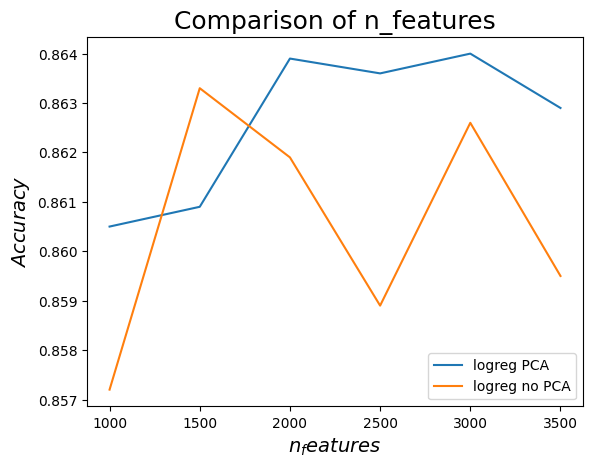

In [22]:
plt.plot(array_features, df_features[df_features.PCA].accuracy, label="logreg PCA")
plt.plot(array_features, df_features[~df_features.PCA].accuracy, label="logreg no PCA")
plt.xlabel("$n_features$", fontsize=14)
plt.ylabel("$Accuracy$", fontsize=14)
plt.title("Comparison of n_features", fontsize=18)
plt.legend()
plt.show()

На графике видим зависимость доли верных ответов от кол-ва признаков для модели logreg. Для данной выборки плато можно заметить только для модели **logreg+PCA**. Относительное плато наблюдается для диаппазона признаков [2000:3000].

При этом нельзя сказать, что качество модели улучшается с увеличением **n_features**, а даже скорее наоборот - по графику мы видим, что наилучшее среднее accuracy наблюдается в диапазоне [1500:3000].

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError